In [2]:
import numpy as np 
import pandas as pd 
import sys
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-11-19 19:39:47.093346: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763581187.338491      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763581187.419430      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [4]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "producersdirectdata.parquet"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "ariellien/producers-direct-2",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

# Combine both language conditions using the logical AND operator (&)
both_eng_mask = (df['response_language'].str.contains('eng', case=False, na=False)) & \
                (df['question_language'].str.contains('eng', case=False, na=False))

# Apply the combined mask to filter the DataFrame. Using .copy() to avoid SettingWithCopyWarning.
df1 = df[both_eng_mask].copy()

# Select the required columns for analysis
CHALLENGE_4_COLUMNS = [
    'question_id',
    'question_topic',
    'question_content',
    'response_content',
    'question_sent',
    'question_user_country_code',
    'question_language',
    'response_language',
]
df1 = df1[CHALLENGE_4_COLUMNS]

# --- B. Data Cleaning and Classification ---

# 1. NaN Handling
# Fill NaN values in the 'question_topic' column with 'General_Topic'
df1['question_topic'].fillna('General_Topic', inplace=True)


# 2. Text Cleaning (Creating 'question_content_cleaned')
def clean_text(text):
    if pd.isna(text):
        return ''
    text = str(text).lower().strip()
    text = re.sub(r'^[qes][\s\.\-]*', '', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Create the cleaned content column
df1['question_content_cleaned'] = df1['question_content'].apply(clean_text)
df1['response_content_cleaned'] = df1['response_content'].apply(clean_text)





# 3. Binary Topic Classification
# List of topics considered 'General' or non-specific
GENERAL_TOPICS_LIST = [
    'General_Topic', 'crop', 'plant', 'animal', 'tree', 'livestock',
    'vegetable', 'bird', 'grass', 'market', 'dog', 'cat', 'poultry'
]

# Create the broad_topic column: Correctly use df1['question_topic'] for the operation
df1['broad_topic'] = df1['question_topic'].apply(
    lambda x: 'General' if x in GENERAL_TOPICS_LIST else 'Specific (Crop/Livestock)'
)

df1.to_csv('df1.csv', index = False)

/tmp/ipykernel_48/1811801336.py:8: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(
/tmp/ipykernel_48/1811801336.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['question_topic'].fillna('General_Topic', inplace=True)


In [7]:
#df1['question_topic'].unique()
df = df1

In [12]:
df.columns

Index(['question_id', 'question_topic', 'question_content', 'response_content',
       'question_sent', 'question_user_country_code', 'question_language',
       'response_language', 'question_content_cleaned',
       'response_content_cleaned', 'broad_topic', 'Question_Length',
       'Specificity_Score', 'Response_Length'],
      dtype='object')

In [15]:
# === Helper Function: Calculate Word Count (Robust Proxy) ===
def calculate_length(text):
    """Calculates the number of words in a text by splitting on spaces."""
    # Note: Handles NaN or None values by returning 0
    if pd.isna(text) or text is None:
        return 0
    # Note: Splits the string by whitespace and returns the length of the resulting list
    return len(str(text).split())

# === Task 1.1: Quantify Question Demand (Question Specificity Score) ===

# 1. Calculate the total word count for the cleaned question content
# Note: Using 'question_content_cleaned' as the source column for farmer questions
df['Question_Length'] = df['question_content_cleaned'].apply(calculate_length)

# 2. Apply Min-Max Normalization to create the Specificity_Score
min_q_length = df['Question_Length'].min()
max_q_length = df['Question_Length'].max()

# Note: Check for division by zero (in case all questions have the same length)
if max_q_length == min_q_length:
    df['Specificity_Score'] = 0.5 # Note: Assign a neutral score if no variation exists
else:
    # Note: Min-Max formula scales the length to the range [0.0, 1.0]
    df['Specificity_Score'] = (df['Question_Length'] - min_q_length) / (max_q_length - min_q_length)


# === Task 1.2: Quantify Answer Supply (Response Score) ===

# 1. Calculate the total word count for the response content
# Note: Using the user-confirmed column 'response_content_cleaned'
df['Response_Length'] = df['response_content_cleaned'].apply(calculate_length)

# 2. Apply Min-Max Normalization to create the Response_Score
min_r_length = df['Response_Length'].min()
max_r_length = df['Response_Length'].max()

# Note: Check for division by zero (in case all questions have the same length)
if max_r_length == min_r_length:
    df['Response_Score'] = 0.5 # Note: Assign a neutral score if no variation exists
else:
    # Note: Min-Max formula scales the length to the range [0.0, 1.0]
    df['Response_Score'] = (df['Response_Length'] - min_r_length) / (max_r_length - min_r_length)


# === Optimized Phase 2 & 3: Topic-Based Cross Analysis and Reporting ===

# Note: Group the data by the provided 'question_topic' for all analyses
grouped_analysis = df.groupby('question_topic').agg(
    # Task 2.3: Question Repetitiveness (Demand Volume)
    Question_Count=('question_topic', 'size'),
    # Task 2.1: Question Specificity (Demand Specificity - Average of individual scores)
    Average_Specificity_Score=('Specificity_Score', 'mean'),
    # Task 2.2: Answer Detail (Supply Detail - Average of individual scores)
    Average_Response_Score=('Response_Score', 'mean')
).reset_index()

# Note: Filter out topics with very few questions for cleaner reporting (e.g., less than 5)
grouped_analysis = grouped_analysis[grouped_analysis['Question_Count'] >= 5]


# 1. Output Report A: Question Repetitiveness (Task 2.3)
print("--- A. QUESTION REPETITIVENESS REPORT (TOP 10) ---")
repetitiveness_report = grouped_analysis[['question_topic', 'Question_Count']].sort_values(by='Question_Count', ascending=False).head(10)
print(repetitiveness_report.to_markdown(index=False, numalign="left", stralign="left"))

# 2. Output Report B: Demand Specificity (Task 2.1)
print("\n--- B. DEMAND SPECIFICITY REPORT - TOP 10, NORMALIZED ---")
demand_report = grouped_analysis[['question_topic', 'Average_Specificity_Score']].sort_values(by='Average_Specificity_Score', ascending=False).head(10)
print(demand_report.to_markdown(index=False, numalign="left", stralign="left"))

# 3. Output Report C: Supply Detail (Task 2.2)
print("\n--- C. SUPPLY DETAIL REPORT - TOP 10, NORMALIZED ---")
supply_report = grouped_analysis[['question_topic', 'Average_Response_Score']].sort_values(by='Average_Response_Score', ascending=False).head(10)
print(supply_report.to_markdown(index=False, numalign="left", stralign="left"))

# Note: Save the full grouped analysis for potential Task 3.1 (Matching Analysis)
#grouped_analysis.to_csv('topic_cross_analysis_final_report.csv', index=False)

--- A. QUESTION REPETITIVENESS REPORT (TOP 10) ---
| question_topic   | Question_Count   |
|:-----------------|:-----------------|
| General_Topic    | 1548673          |
| cattle           | 1101795          |
| maize            | 1077312          |
| chicken          | 1005261          |
| plant            | 909515           |
| tomato           | 552034           |
| crop             | 537850           |
| bean             | 392026           |
| banana           | 311987           |
| pig              | 291553           |

--- B. DEMAND SPECIFICITY REPORT - TOP 10, NORMALIZED ---
| question_topic   | Average_Specificity_Score   |
|:-----------------|:----------------------------|
| peach            | 0.147967                    |
| pear             | 0.147599                    |
| setaria          | 0.137103                    |
| radish           | 0.129927                    |
| sesame           | 0.125888                    |
| cashew-nut       | 0.118622                    |
| 

In [16]:
# --- Data Reconstruction from previous reports ---

# Report A: QUESTION REPETITIVENESS (Demand Volume)
data_a = {
    'question_topic': ['General_Topic', 'cattle', 'maize', 'chicken', 'plant', 'tomato', 'crop', 'bean', 'banana', 'pig'],
    'Question_Count': [1548673, 1101795, 1077312, 1005261, 909515, 552034, 537850, 392026, 311987, 291553]
}
df_a = pd.DataFrame(data_a)

# Report B: DEMAND SPECIFICITY (Question Complexity)
data_b = {
    'question_topic': ['peach', 'pear', 'setaria', 'radish', 'sesame', 'cashew-nut', 'cyprus', 'collard-greens', 'olive', 'chickpea'],
    'Average_Specificity_Score': [0.147967, 0.147599, 0.137103, 0.129927, 0.125888, 0.118622, 0.115911, 0.113627, 0.113123, 0.112513]
}
df_b = pd.DataFrame(data_b)

# Report C: SUPPLY DETAIL (Answer Detail)
data_c = {
    'question_topic': ['rye', 'pigeon-pea', 'rapeseed', 'bee', 'poultry', 'courgette', 'leucaena', 'cashew-nut', 'mushroom', 'banana'],
    'Average_Response_Score': [0.0386701, 0.0354653, 0.0348971, 0.0331408, 0.0325912, 0.0323975, 0.0314919, 0.0310701, 0.0308776, 0.0306813]
}
df_c = pd.DataFrame(data_c)

# Set a consistent style for all charts
sns.set_theme(style="whitegrid")

# --- Chart A: Question Repetitiveness (Demand Volume) ---
plt.figure(figsize=(10, 6))
# Sort the data for plotting
df_a_sorted = df_a.sort_values(by='Question_Count', ascending=False)
sns.barplot(x='Question_Count', y='question_topic', data=df_a_sorted, palette="Blues_d")

# Add labels and title (using English as requested previously)
plt.title('A. Demand Volume: Top 10 Most Frequent Topics', fontsize=16)
plt.xlabel('Demand Volume (Question Count)', fontsize=12)
plt.ylabel('Question Topic', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('report_a_repetitiveness_seaborn.png')
plt.close()

# --- Chart B: Demand Specificity (Question Complexity) ---
plt.figure(figsize=(10, 6))
df_b_sorted = df_b.sort_values(by='Average_Specificity_Score', ascending=False)
sns.barplot(x='Average_Specificity_Score', y='question_topic', data=df_b_sorted, palette="Reds_d")

plt.title('B. Demand Specificity: Question Complexity Ranking', fontsize=16)
plt.xlabel('Farmer Demand Complexity Score (0-1)', fontsize=12)
plt.ylabel('Question Topic', fontsize=12)
plt.tight_layout()
plt.savefig('report_b_demand_specificity_seaborn.png')
plt.close()

# --- Chart C: Supply Detail (Answer Detail) ---
plt.figure(figsize=(10, 6))
df_c_sorted = df_c.sort_values(by='Average_Response_Score', ascending=False)
sns.barplot(x='Average_Response_Score', y='question_topic', data=df_c_sorted, palette="Greens_d")

plt.title('C. Supply Detail: Knowledge Supply Detail Ranking', fontsize=16)
plt.xlabel('Knowledge Supply Detail Score (0-1)', fontsize=12)
plt.ylabel('Question Topic', fontsize=12)
plt.tight_layout()
plt.savefig('report_c_supply_detail_seaborn.png')
plt.close()

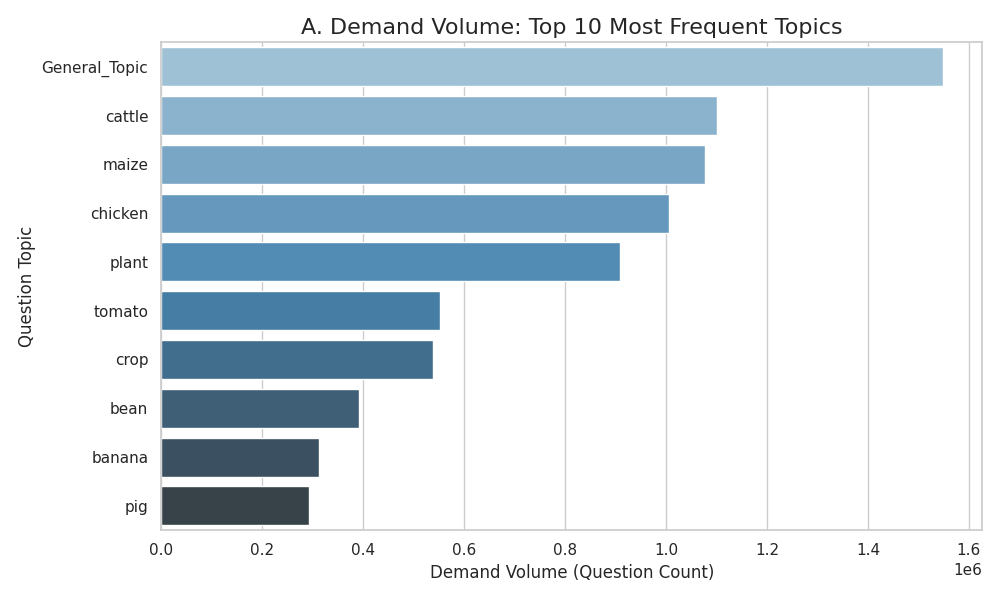

In [18]:
Image(filename='report_a_repetitiveness_seaborn.png')

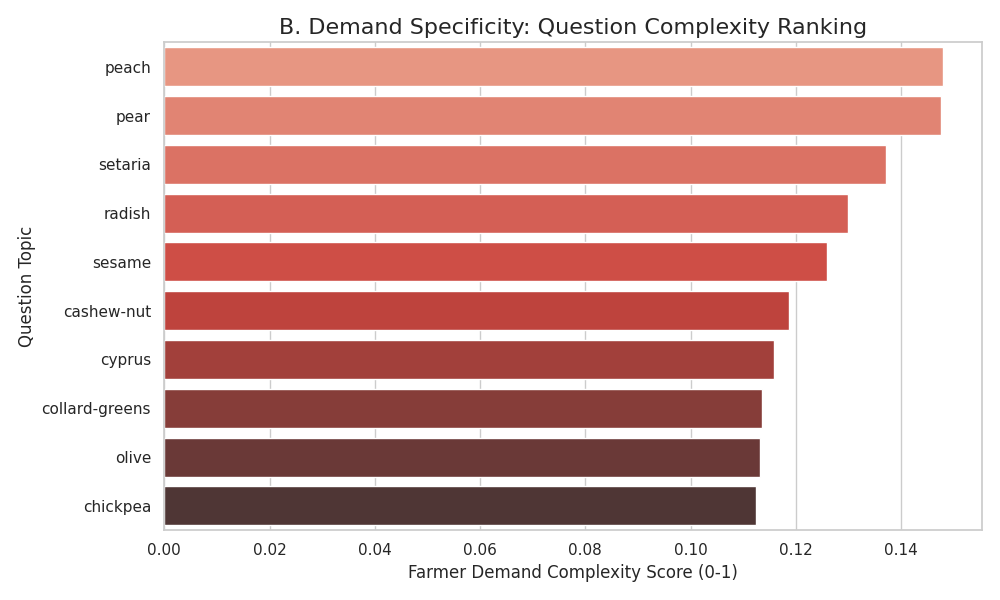

In [19]:
Image(filename='report_b_demand_specificity_seaborn.png')

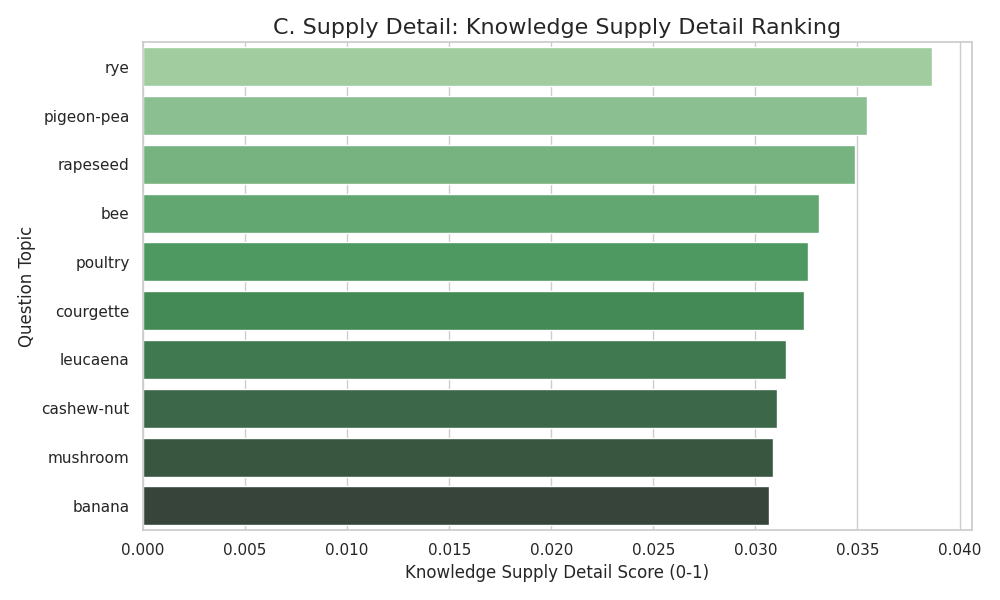

In [20]:
Image(filename='report_c_supply_detail_seaborn.png')